## Predictive modeling 
### Week 5: Regularization

In [1]:
# libraries
import pandas as pd # process dataframe
import numpy as np # scientific calculation
import seaborn as sns # visualization complete stastistics
import matplotlib.pyplot as plt # visualization
from sklearn.model_selection import train_test_split # train test split
from sklearn.preprocessing import MinMaxScaler # load scaler from sklearn
from sklearn.metrics import mean_squared_error # mse 
import missingno as msno # miss data visuals

import statsmodels.api as sm # statsmodels to build regression model

### 0. Dataset and some cleansing job

In [2]:
data = pd.read_csv('../cars_dataset/train-data.csv')
train_0 = data.drop(columns=['Unnamed: 0', 'New_Price'])

# strings to float transformation
train_0['Mileage'] = train_0['Mileage']\
    .str.replace('km/kg','').str.replace('kmpl','').astype(float)
train_0['Engine'] = train_0['Engine'].str.replace('CC','').astype(float)
train_0['Power'] = train_0['Power']\
    .str.replace('bhp','').str.replace('null', '0').fillna('0').astype(float)

# perform train test split 
X_all = train_0.drop(columns=['Price'])
y_all = train_0[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size=0.3, 
                                                    random_state=42)

# check data size 
print('Training set size: ', len(X_train)) # 70% of total data
print('Test set size: ', len(X_test)) # 30% of total data

Training set size:  4213
Test set size:  1806


### 1. Data processing

In [3]:
# Tukey's method
def tukeys_method(df, variable, q_range=1.5):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = q_range*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    outliers_poss = []
    
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_poss, inner_fence_le, inner_fence_ue 

#### 1.1 Training data

In [4]:
X_train_1 = X_train.copy()

# outliers removal 
outlier_indices, lower_limit, upper_limit = tukeys_method(y_train,'Price')
print('Lower limit: ', lower_limit)
print('Upper limit: ', upper_limit)

y_train_ul = y_train[y_train['Price']>upper_limit]
X_train_1 = X_train_1.drop(index=y_train_ul.index)
y_train_1 = y_train.drop(index=y_train_ul.index)

# missing data treatment
X_train_1['Mileage'] = X_train_1['Mileage'].fillna(X_train_1['Mileage'].mean())
X_train_1['Engine'] = X_train_1['Engine'].fillna(X_train_1['Engine'].median())
X_train_1['Seats'] = X_train_1['Seats'].fillna(int(X_train_1['Seats'].mode()))

# year transformation
X_train_1['Age'] = 2021 - X_train_1['Year']
X_train_1 = X_train_1.drop(columns=['Year'])

# categorical encoding
Location_enc = pd.get_dummies(X_train_1[['Location']])
Fuel_Type_enc = pd.get_dummies(X_train_1[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_train_1[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_train_1[['Owner_Type']])
X_train_1 = X_train_1.drop(columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_train_1 = pd.concat([X_train_1, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

# define data to be scaled 
x = X_train_1.drop(columns=['Name'])

scaler = MinMaxScaler() # instantiate the scaler
scaler_fit = scaler.fit(x) # fit the scaler on the data
x_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_train_1 = pd.DataFrame(x_sc, columns=x.columns)
X_train_1.info()

Lower limit:  -6.100000000000001
Upper limit:  19.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          3716 non-null   float64
 1   Mileage                    3716 non-null   float64
 2   Engine                     3716 non-null   float64
 3   Power                      3716 non-null   float64
 4   Seats                      3716 non-null   float64
 5   Age                        3716 non-null   float64
 6   Location_Ahmedabad         3716 non-null   float64
 7   Location_Bangalore         3716 non-null   float64
 8   Location_Chennai           3716 non-null   float64
 9   Location_Coimbatore        3716 non-null   float64
 10  Location_Delhi             3716 non-null   float64
 11  Location_Hyderabad         3716 non-null   float64
 12  Location_Jaipur            3716 non-null   float64
 

#### 1.2 Test data

In [5]:
X_test_1 = X_test.copy()
## missing data imputation
X_test_1['Mileage'] = X_test_1['Mileage'].fillna(X_test_1['Mileage'].mean())
X_test_1['Engine'] = X_test_1['Engine'].fillna(X_test_1['Engine'].median())
X_test_1['Seats'] = X_test_1['Seats'].fillna(int(X_test_1['Seats'].mode()))

## year to age transformation
X_test_1['Age'] = 2021 - X_test_1['Year']
X_test_1 = X_test_1.drop(columns=['Year'])

## categorical transformation
# encoding
Location_enc = pd.get_dummies(X_test_1[['Location']])
Fuel_Type_enc = pd.get_dummies(X_test_1[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_test_1[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_test_1[['Owner_Type']])

# adding them back the test data 
X_test_1 = X_test_1.drop(columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_test_1 = pd.concat([X_test_1, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

## min-max scaling
# define data to be scaled 
x = X_test_1.drop(columns=['Name'])
X_test_1_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_test_1 = pd.DataFrame(X_test_1_sc, columns=x.columns)
X_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          1806 non-null   float64
 1   Mileage                    1806 non-null   float64
 2   Engine                     1806 non-null   float64
 3   Power                      1806 non-null   float64
 4   Seats                      1806 non-null   float64
 5   Age                        1806 non-null   float64
 6   Location_Ahmedabad         1806 non-null   float64
 7   Location_Bangalore         1806 non-null   float64
 8   Location_Chennai           1806 non-null   float64
 9   Location_Coimbatore        1806 non-null   float64
 10  Location_Delhi             1806 non-null   float64
 11  Location_Hyderabad         1806 non-null   float64
 12  Location_Jaipur            1806 non-null   float64
 13  Location_Kochi             1806 non-null   float

### 2. Model fitting

In [6]:
# fit the model
X = sm.add_constant(X_train_1)
y = y_train_1.reset_index(drop=True)
lr = sm.OLS(y, X).fit()

display(lr.summary())

# predict the model
X = X_test_1
X = sm.add_constant(X)
tst_pred = lr.predict(X)
print('Test RMSE: ', mean_squared_error(y_test, tst_pred, squared=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     392.4
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        16:55:04   Log-Likelihood:                -8060.4
No. Observations:                3716   AIC:                         1.617e+04
Df Residuals:                    3691   BIC:                         1.633e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.6388      0.358     12.972      0.000       3.938       5.340
Kilometers_Driven            -6.0025      0.846     -7.095      0.000      -7.661      -4.344
Mileage                      -4.9480      0.462    -10.708      0.000      -5.854      -4.042
Engine                        8.4997      0.724     11.744      0.000       7.081       9.919
Power                        10.0872      0.575     17.534      0.000       8.959      11.215
Seats                        -1.5041      0.609     -2.470      0.014      -2.698      -0.310
Age                         -10.6873      0.306    -34.896      0.000     -11.288     -10.087
Location_Ahmedabad            0.7487      0.169      4.430      0.000       0.417       1.080
Location_Bangalore            0.9713      0.144      6.725      0.000       0.688       1.255
Location_Chennai              0.3899      0.122      3.206      0.001       0.151       0.628
Location_Coimbatore           1.1160      0.117      9.553      0.000       0.887       1.345
Location_Delhi                0.0452      0.116      0.390      0.697      -0.182       0.272
Location_Hyderabad            0.7944      0.105      7.569      0.000       0.589       1.000
Location_Jaipur               0.3258      0.129      2.520      0.012       0.072       0.579
Location_Kochi                0.3873      0.112      3.470      0.001       0.168       0.606
Location_Kolkata             -0.6207      0.117     -5.323      0.000      -0.849      -0.392
Location_Mumbai               0.1381      0.103      1.337      0.181      -0.064       0.341
Location_Pune                 0.3429      0.107      3.200      0.001       0.133       0.553
Fuel_Type_CNG                -0.3728      0.512     -0.729      0.466      -1.376       0.630
Fuel_Type_Diesel              0.1698      0.430      0.395      0.693      -0.674       1.013
Fuel_Type_Electric            7.4471      1.759      4.234      0.000       3.999      10.896
Fuel_Type_LPG                -0.9763      0.733     -1.332      0.183      -2.414       0.461
Fuel_Type_Petrol             -1.6290      0.417     -3.904      0.000      -2.447      -0.811
Transmission_Automatic        3.3358      0.183     18.214      0.000       2.977       3.695
Transmission_Manual           1.3030      0.190      6.864      0.000       0.931       1.675
Owner_Type_First              1.4633      0.238      6.141      0.000       0.996       1.930
Owner_Type_Fourth & Above     0.9064      0.750      1.209      0.227      -0.563       2.376
Owner_Type_Second             1.2309      0.242      5.087      0.000       0.756       1.705
Owner_Type_Third              1.0383      0.297      3.498      0.000       0.456       1.620
===========================================================================

Test RMSE:  8.432747603727313


C:\Users\natanop.pimonsathian\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


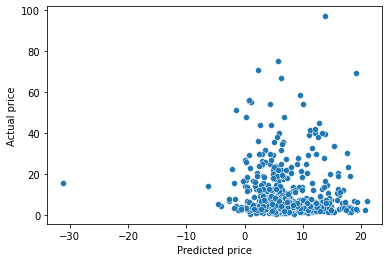

In [7]:
# prediction plot
sns.scatterplot(tst_pred, y_test['Price'])
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.show();

### 3. Model fitting improvement 
- Changing the outlier cutoff to be 3 IQR
- Log scaling on the target variable
- Recode cities into two zones high and low GDP

In [8]:
high_gdp = ['Coimbatore', 'Mumbai', 'Pune']
medium_gdp = ['Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad']
low_gdp = ['Jaipur', 'Kochi', 'Kolkata']

In [9]:
X_train_2 = X_train.copy()

# outliers removal 
outlier_indices, lower_limit, upper_limit = tukeys_method(y_train, 'Price', 3.0)
print('Lower limit: ', lower_limit)
print('Upper limit: ', upper_limit)

y_train_ul = y_train[y_train['Price']>upper_limit]
X_train_2 = X_train_2.drop(index=y_train_ul.index)
y_train_2 = y_train.drop(index=y_train_ul.index)

# missing data treatment
X_train_2['Mileage'] = X_train_2['Mileage'].fillna(X_train_2['Mileage'].mean())
X_train_2['Engine'] = X_train_2['Engine'].fillna(X_train_2['Engine'].median())
X_train_2['Seats'] = X_train_2['Seats'].fillna(int(X_train_2['Seats'].mode()))

# year transformation
X_train_2['Age'] = 2021 - X_train_2['Year']
X_train_2 = X_train_2.drop(columns=['Year'])

# categorical encoding
X_train_2['GDP'] = np.where(X_train_2['Location'].isin(high_gdp), 'High',
                   np.where(X_train_2['Location'].isin(medium_gdp), 'Medium', 'Low'))
Location_enc = pd.get_dummies(X_train_2[['GDP']])
Fuel_Type_enc = pd.get_dummies(X_train_2[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_train_2[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_train_2[['Owner_Type']])
X_train_2 = X_train_2.drop(columns=['Location', 'GDP', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_train_2 = pd.concat([X_train_2, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

# define data to be scaled 
x = X_train_2.drop(columns=['Name'])

scaler = MinMaxScaler() # instantiate the scaler
scaler_fit = scaler.fit(x) # fit the scaler on the data
x_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_train_2 = pd.DataFrame(x_sc, columns=x.columns)
X_train_2.info()

Lower limit:  -15.700000000000003
Upper limit:  29.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          3950 non-null   float64
 1   Mileage                    3950 non-null   float64
 2   Engine                     3950 non-null   float64
 3   Power                      3950 non-null   float64
 4   Seats                      3950 non-null   float64
 5   Age                        3950 non-null   float64
 6   GDP_High                   3950 non-null   float64
 7   GDP_Low                    3950 non-null   float64
 8   GDP_Medium                 3950 non-null   float64
 9   Fuel_Type_CNG              3950 non-null   float64
 10  Fuel_Type_Diesel           3950 non-null   float64
 11  Fuel_Type_Electric         3950 non-null   float64
 12  Fuel_Type_LPG              3950 non-null   float64


In [10]:
X_test_2 = X_test.copy()
## missing data imputation
X_test_2['Mileage'] = X_test_2['Mileage'].fillna(X_test_2['Mileage'].mean())
X_test_2['Engine'] = X_test_2['Engine'].fillna(X_test_2['Engine'].median())
X_test_2['Seats'] = X_test_2['Seats'].fillna(int(X_test_2['Seats'].mode()))

## year to age transformation
X_test_2['Age'] = 2021 - X_test_2['Year']
X_test_2 = X_test_2.drop(columns=['Year'])

## categorical transformation
# categorical encoding
X_test_2['GDP'] = np.where(X_test_2['Location'].isin(high_gdp), 'High',
                   np.where(X_test_2['Location'].isin(medium_gdp), 'Medium', 'Low'))
Location_enc = pd.get_dummies(X_test_2[['GDP']])
Fuel_Type_enc = pd.get_dummies(X_test_2[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_test_2[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_test_2[['Owner_Type']])

# adding them back the test data 
X_test_2 = X_test_2.drop(columns=['Location', 'GDP', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_test_2 = pd.concat([X_test_2, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

## min-max scaling
# define data to be scaled 
x = X_test_2.drop(columns=['Name'])
X_test_2_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_test_2 = pd.DataFrame(X_test_2_sc, columns=x.columns)
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          1806 non-null   float64
 1   Mileage                    1806 non-null   float64
 2   Engine                     1806 non-null   float64
 3   Power                      1806 non-null   float64
 4   Seats                      1806 non-null   float64
 5   Age                        1806 non-null   float64
 6   GDP_High                   1806 non-null   float64
 7   GDP_Low                    1806 non-null   float64
 8   GDP_Medium                 1806 non-null   float64
 9   Fuel_Type_CNG              1806 non-null   float64
 10  Fuel_Type_Diesel           1806 non-null   float64
 11  Fuel_Type_Electric         1806 non-null   float64
 12  Fuel_Type_LPG              1806 non-null   float64
 13  Fuel_Type_Petrol           1806 non-null   float

In [11]:
# fit the model
X = sm.add_constant(X_train_2)
y = y_train_2.reset_index(drop=True)
y = np.log(y)
lr = sm.OLS(y, X).fit()

display(lr.summary())

lr_trn_pred = lr.predict(X)
lr_trn_pred = np.exp(lr_trn_pred)
print('Training RMSE: ', mean_squared_error(y_train_2, lr_trn_pred, squared=False))

# predict the model
x = X_test_2
X = sm.add_constant(x)
tst_pred = lr.predict(X)
print('Test RMSE: ', mean_squared_error(y_test, np.exp(tst_pred), squared=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1219.
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        16:55:04   Log-Likelihood:                -859.92
No. Observations:                3950   AIC:                             1754.
Df Residuals:                    3933   BIC:                             1861.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9720      0.044     22.093      0.000       0.886       1.058
Kilometers_Driven            -0.7313      0.115     -6.362      0.000      -0.957      -0.506
Mileage                      -0.7221      0.061    -11.766      0.000      -0.842      -0.602
Engine                        1.3883      0.103     13.438      0.000       1.186       1.591
Power                         2.2650      0.094     24.118      0.000       2.081       2.449
Seats                        -0.3110      0.084     -3.720      0.000      -0.475      -0.147
Age                          -2.5119      0.041    -61.495      0.000      -2.592      -2.432
GDP_High                      0.3443      0.016     21.414      0.000       0.313       0.376
GDP_Low                       0.2405      0.017     14.514      0.000       0.208       0.273
GDP_Medium                    0.3872      0.016     24.052      0.000       0.356       0.419
Fuel_Type_CNG                -0.0070      0.072     -0.096      0.923      -0.149       0.135
Fuel_Type_Diesel              0.1776      0.061      2.904      0.004       0.058       0.298
Fuel_Type_Electric            1.0360      0.249      4.169      0.000       0.549       1.523
Fuel_Type_LPG                -0.1023      0.104     -0.986      0.324      -0.306       0.101
Fuel_Type_Petrol             -0.1323      0.060     -2.217      0.027      -0.249      -0.015
Transmission_Automatic        0.6348      0.023     28.183      0.000       0.591       0.679
Transmission_Manual           0.3371      0.024     14.186      0.000       0.291       0.384
Owner_Type_First              0.2859      0.034      8.526      0.000       0.220       0.352
Owner_Type_Fourth & Above     0.3390      0.106      3.206      0.001       0.132       0.546
Owner_Type_Second             0.2270      0.034      6.658      0.000       0.160       0.294
Owner_Type_Third              0.1200      0.042      2.877      0.004       0.038       0.202
==============================================================================
Omnibus:                      315.590   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1692.159
Skew:                          -0.153   Prob(JB):                         0.00
Kurtosis:                       6.192   Cond. No.                     2.20e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Training RMSE:  2.924272055861621
Test RMSE:  6.166313201388538


<AxesSubplot:ylabel='Price'>

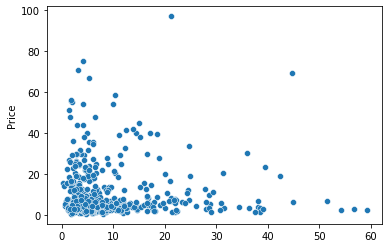

In [12]:
sns.scatterplot(x=np.exp(tst_pred), y=y_test['Price'])

### 4. Reduce overfitting - Regularization 
- Regularization means adding a term (penalty) to the regression formula. 
- Addtionally, regularization could be also used as a feature selection technique. 
- We will be demonstrating lasso regression, which adding the sum squared of coefficient to the model.

#### 4.1 Demo: Ridge regression with parameter tuning

In [13]:
from sklearn.linear_model import Ridge

X = X_train_2
y = y_train_2.reset_index(drop=True)

model_ridge = Ridge(alpha=100)
model_ridge.fit(X, y)

train_pred = model_ridge.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

pred =  model_ridge.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

Training RMSE:  3.541636790466142
Test RMSE:  8.52558239683613


#### 4.2 Excerise: Lasso regression with parameter tuning
- import Lasso regression instead of Ridge
- Try fitting the model using alpha = 1 and alpha = 1000

In [14]:
from sklearn.linear_model import Lasso

X = X_train_2
y = y_train_2.reset_index(drop=True)

model_lasso = Lasso(alpha=100)
model_lasso.fit(X, y)

train_pred = model_lasso.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

pred =  model_lasso.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))


Training RMSE:  5.74474591526858
Test RMSE:  11.33376584116888


#### 4.3 Demo: Cross validation for ridge regression

In [15]:
from sklearn.linear_model import RidgeCV 

X = X_train_2
y = y_train_2.reset_index(drop=True)

# define cross-validation fold and parameter to be tuned
cv = 10
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 1000]

# define model
model = RidgeCV(alphas=alphas, cv=cv, normalize=False)

# fit model
model.fit(X, y)

# display lambda that produced the lowest test MSE
print(model.alpha_)

# report training error
train_pred = model.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

# report test error
pred =  model.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

0.5
Training RMSE:  3.0321302243850132
Test RMSE:  7.763631674864469


In [16]:
results = pd.DataFrame({'Feature Name': X_train_2.columns, 
                        'Coefficient': model.coef_.ravel()})
results.sort_values(by='Coefficient', ascending=False)

,Feature Name,Coefficient
3,Power,18.584015
2,Engine,6.495754
11,Fuel_Type_Electric,3.264113
14,Transmission_Automatic,1.618782
10,Fuel_Type_Diesel,0.436898
8,GDP_Medium,0.276230
16,Owner_Type_First,0.251491
6,GDP_High,0.072616
18,Owner_Type_Second,0.003750
17,Owner_Type_Fourth & Above,-0.121450


#### 4.4 Demo: Cross validation for lasso regression

In [17]:
from sklearn.linear_model import LassoCV 

X = X_train_2
y = y_train_2.reset_index(drop=True)

# define cross-validation fold and parameter to be tuned
cv = 10
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 1000]

# define model
model = LassoCV(alphas=alphas, cv=cv, normalize=False)

# fit model
model.fit(X, y)

# display lambda that produced the lowest test MSE
print(model.alpha_)

# report training error
train_pred = model.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

# report test error
pred =  model.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

0.001
Training RMSE:  3.032643016421251
Test RMSE:  7.7578991465821145


C:\Users\natanop.pimonsathian\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [18]:
results = pd.DataFrame({'Feature Name': X_train_2.columns, 
                        'Coefficient': model.coef_.ravel()})
results.sort_values(by='Coefficient', ascending=False)

,Feature Name,Coefficient
3,Power,19.197499
2,Engine,5.940295
14,Transmission_Automatic,3.213555
11,Fuel_Type_Electric,1.022091
10,Fuel_Type_Diesel,0.601489
16,Owner_Type_First,0.242213
8,GDP_Medium,0.204597
18,Owner_Type_Second,0.000000
17,Owner_Type_Fourth & Above,-0.000000
6,GDP_High,-0.000000


<AxesSubplot:xlabel='Kilometers_Driven', ylabel='Mileage'>

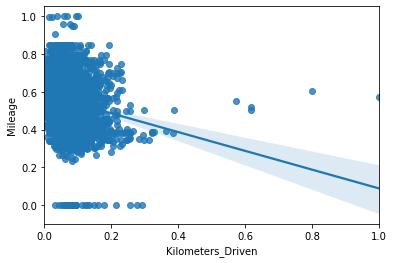

In [19]:
sns.regplot(x='Kilometers_Driven', y='Mileage', data=X_train_2)

<AxesSubplot:xlabel='Power', ylabel='Mileage'>

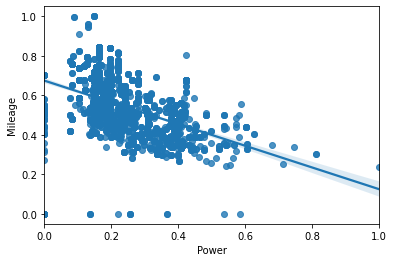

In [20]:
sns.regplot(x='Power', y='Mileage', data=X_train_2)

In [37]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def rfr_model(X, y):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"],                               
                                random_state=42, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_squared_error')

    return scores, best_params

In [38]:
scores, best_params = rfr_model(X=X_train_2, y=y_train_2.reset_index(drop=True))

C:\Users\natanop.pimonsathian\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\natanop.pimonsathian\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\natanop.pimonsathian\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\natanop.pimonsathian\Anaconda3\lib\site-packages\sklearn\model_selection\_validat

In [42]:
best_params

{'max_depth': 9, 'n_estimators': 100}

In [39]:
score

array([-5.20130431, -4.46610695, -5.66362383, -4.43215637, -4.86554377,
       -4.13332277, -5.11392945, -5.14479696, -5.05280033, -3.74698291])

In [40]:
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"])
rfr.fit(X, y)

# report training error
train_pred = rfr.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

# report test error
pred =  rfr.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

<ipython-input-40-f7b4e701d5e9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X, y)


Training RMSE:  1.224175570417781
Test RMSE:  6.537136904076575


In [45]:
rfr.feature_importances_

array([2.89543412e-02, 2.75587802e-02, 5.49918023e-02, 6.63011064e-01,
       9.14385613e-03, 1.78559692e-01, 1.63870249e-03, 1.82237271e-03,
       2.10503262e-03, 5.78404143e-06, 6.80457175e-03, 4.23015731e-04,
       8.00477700e-08, 4.53729770e-03, 8.53104885e-03, 9.30684874e-03,
       1.33767475e-03, 1.87208610e-06, 1.14304730e-03, 1.23116139e-04])

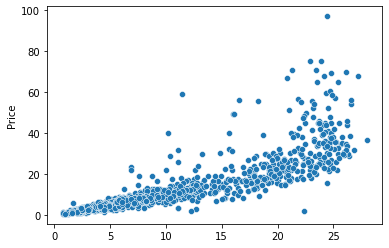

In [41]:
sns.scatterplot(x=pred, y=y_test['Price']);

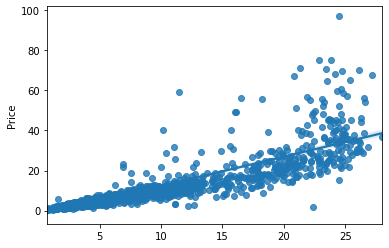

In [43]:
sns.regplot(x=pred, y=y_test['Price']);